In [154]:
# if packages are missing, please uncomment the lines below and run cell
# %pip install -r ./requirements.txt

# 1.26.4 is needed for something else 
# The following depend on your gpu and ur cuda-enabledness. 
# %pip install torch==2.3.0+cpu
# %pip install torchvision==0.18.0+cpu
# %pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu121/torch2.3/index.html

In [155]:
# python standard library
import itertools
import json
import os
import threading
from collections.abc import Callable, Iterable
from enum import Enum, auto
from functools import wraps
# yes i like static typing why do you ask?
from typing import Any, Optional, Sequence, Union

# not python standard library
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from safetensors.torch import load_file as safe_load
from baseline_model import get_flowers_dataloaders, set_seed, train_epoch, validate
from connection_test import hugging_face_connectivity_test
from tqdm.notebook import tqdm

In [156]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed()
train_loader, val_loader, test_loader = get_flowers_dataloaders(batch_size=32)
print(device)

Seed set to 42


cuda


### Model creation, significant overlap with baseline_model

In [157]:
def freeze_head(model, model_name):
	if "vit" in model_name:
		for name, param in model.named_parameters():
			if not name.startswith("head"):  # ViT classifier head
				param.requires_grad = False
	elif "resnet" in model_name:
		for name, param in model.named_parameters():
			if "fc" not in name:  # 'fc' is the final classifier for resnets
				param.requires_grad = False
	else:
		raise NotImplementedError(
			f"Freeze head received unknown model type {model_name}"
		)
	return model


def create_model_with_timeout(model_name, num_classes, device, timeout=10):
	"""
	Create a timm model safely with timeout and fallback logic.
	Tries local weights first, then checks Hugging Face and retries online if accessible.
	"""
	model_container = {}

	def target():
		try:
			model = timm.create_model(
				model_name, pretrained=False, num_classes=num_classes
			)

			# --- Locate local weights ---
			weights_dir = os.path.join("..", "original_weights")
			safe_path = os.path.join(weights_dir, f"{model_name}.safetensors")
			pth_path = os.path.join(weights_dir, f"{model_name}.pth")

			if os.path.exists(safe_path):
				weight_path = safe_path
			elif os.path.exists(pth_path):
				weight_path = pth_path
			else:
				raise FileNotFoundError(
					f"No local weight file found for '{model_name}' in '{weights_dir}'"
				)

			# --- Load local weights safely ---
			try:
				if weight_path.endswith(".safetensors"):
					state_dict = safe_load(weight_path)
				else:
					# PyTorch .pth / .pt file
					state_dict = torch.load(
						weight_path, map_location="cpu", weights_only=False
					)
			except Exception as e:
				raise RuntimeError(
					f"Error loading local weight file '{weight_path}': {e}"
				)

			# --- Apply weights ---
			try:
				checkpoint = state_dict.copy()
				for key in list(checkpoint.keys()):
					if key.startswith("fc.") or key.startswith("head."):
						del checkpoint[key]

				# Now load safely
				missing, unexpected = model.load_state_dict(checkpoint, strict=False)
				print(
					f"Ignored missing keys: {missing}"
				)  # should include 'fc.weight', 'fc.bias'
				print(f"Ignored unexpected keys: {unexpected}")
			except Exception as e:
				raise RuntimeError(f"Weight mismatch for '{model_name}': {e}")

			# --- Move to device ---
			model_container["model"] = model.to(device)

		except Exception as e:
			model_container["error"] = str(e)

	# --- Run model creation in separate thread with timeout ---
	thread = threading.Thread(target=target)
	thread.start()
	thread.join(timeout)

	if thread.is_alive():
		raise TimeoutError(f"Creating model '{model_name}' timed out after {timeout}s.")

	# --- Handle failure: fallback path ---
	if "error" in model_container:
		print(f"Local load failed: {model_container['error']}")

		try:
			print("\n")
			hf_status = hugging_face_connectivity_test()
		except Exception as e:
			raise RuntimeError(f"Hugging Face connectivity test failed to run: {e}")

		# interpret test output if no connection
		if not hf_status:
			raise RuntimeError(
				"Local Weights not found and could not reach Hugging Face. Check your DNS, VPN, or network access."
			)

		# --- Retry with online download ---
		print("Retrying model creation via TIMM (pretrained=True)...")
		try:
			model = timm.create_model(
				model_name, pretrained=True, num_classes=num_classes
			)
			model_container["model"] = model.to(device)
			print(
				f"✅ Successfully downloaded and loaded '{model_name}' from Hugging Face."
			)
		except Exception as e:
			raise RuntimeError(
				f"Retried online download but still failed for '{model_name}': {e}"
			)

	model_container["model"] = freeze_head(model_container["model"], model_name)
	return model_container["model"]

# Different Depths

In [158]:
class EarlyStopper:
	def __init__(self, patience=10, min_delta=0):
		self.patience = patience
		self.min_delta = min_delta
		self.counter = 0
		self.min_validation_loss = np.inf

	def __call__(self, validation_loss):
		if validation_loss < self.min_validation_loss:
			self.min_validation_loss = validation_loss
			self.counter = 0
		elif validation_loss > (self.min_validation_loss + self.min_delta):
			self.counter += 1
			if self.counter >= self.patience:
				return True
		return False

In [159]:
def get_performance(
	model_name: str,
	num_classes: int = 102,
	num_epochs: int = 30,
	batch_size: int = 32,
	lr: float = 0.001,
	weight_decay: float = 1e-4,
	scheduler_step_size: int = 10,
	scheduler_gamma: float = 0.1,
	device: str = "cuda" if torch.cuda.is_available() else "cpu",
	model_transform: Callable[[nn.Module], nn.Module] | None = None,
):
	"""
	Train and evaluate any timm model (ViT, ResNet, etc.).
	Note: model_transform must unfreeze layers by itself. By default, all old pretrained layers are frozen
	"""
	# === 1. Setup ===
	history = {
		"train_loss": [],
		"train_acc": [],
		"val_loss": [],
		"val_acc": [],
		"test_loss": float,
		"test_acc": float,
	}
	best_val_acc = 0.0
	best_model_state = None
	early_stop = EarlyStopper()

	# === 2. Create model ===
	model = create_model_with_timeout(
		model_name, num_classes=num_classes, device=device
	)
	if model_transform is not None:
		model = model_transform(model)

	criterion = nn.CrossEntropyLoss().to(device)
	optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
	scheduler = optim.lr_scheduler.StepLR(
		optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma
	)

	assert num_epochs > 0, "Num epochs must be greater than 0!"

	# === 3. Training Loop ===
	for epoch in tqdm(
		range(num_epochs), desc=f"Training Epochs ({model_name})", unit="epoch"
	):
		current_lr = scheduler.get_last_lr()[0]

		train_loss, train_acc = train_epoch(
			model, train_loader, criterion, optimizer, device
		)
		val_loss, val_acc = validate(model, val_loader, criterion, device)
		scheduler.step()

		# Record metrics
		for key, val in zip(
			["train_loss", "train_acc", "val_loss", "val_acc"],
			[train_loss, train_acc, val_loss, val_acc],
		):
			history[key].append(val)

		# Save best model
		if val_acc > best_val_acc:
			best_val_acc = val_acc
			best_model_state = model.state_dict().copy()

		if early_stop(val_loss):
			tqdm.write("Early stopping triggered.")
			break

		tqdm.write(
			f"Epoch [{epoch + 1}/{num_epochs}] "
			f"LR: {current_lr:.6f} | "
			f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
			f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
		)

	# === 4. Test Evaluation ===
	test_loss, test_acc = validate(
		model, test_loader, criterion, device, valid_or_test="test"
	)
	history["test_loss"] = test_loss
	history["test_acc"] = test_acc

	assert best_val_acc > 0.0 and best_model_state is not None, (
		"The model validation accuracy is 0! Check your data or training loop."
	)

	model.load_state_dict(best_model_state)
	print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
	print(f"\nTest Accuracy: {test_acc:.2f}%")

	num_params = sum(p.numel() for p in model.parameters())
	history["num_params"] = num_params
	return model, history, num_params

### Model Sources and Experiment Setup

If you need to **download the models manually**, here are the sources:

- [ResNet18](https://huggingface.co/timm/resnet18.tv_in1k/tree/main)  
- [ResNet34](https://huggingface.co/timm/resnet34.tv_in1k/tree/main)  
- [ResNet50](https://huggingface.co/timm/resnet50.tv_in1k/tree/main)  
- [ResNet101](https://huggingface.co/timm/resnet101.tv_in1k/tree/main)  
- [ResNet152](https://huggingface.co/timm/resnet152.tv_in1k/tree/main)  
- [ViT Base Patch32 (ImageNet-21k)](https://huggingface.co/timm/vit_base_patch32_224.orig_in21k/tree/main)  
- [ViT Base Patch16 (ImageNet-21k)](https://huggingface.co/timm/vit_base_patch16_224.orig_in21k/tree/main)

---

#### Notes
- **ResNet memory** scales *linearly* with the number of layers — this is because intermediate activations must be stored for backpropagation.  
	> My 7.6 GB GPU should handle all ResNet variants; your GPU may differ
- **ViT memory** scales *quadratically* (roughly inversely with patch size).  
	> My GPU likely cannot handle `vit_large` or `vit_huge`.
- **Training datasets differ:**
	- ResNets use **ImageNet-1k**
	- ViTs use **ImageNet-21k**
- Chosen ViT models are ones without heavy modern augmentations, for a fairer comparison.

---


In [160]:
# === Model Setup ===
resnet_histories = {}

# Default list for full experiments
model_names_default = [
	"resnet18",
	"resnet34",
	"resnet50",
	"resnet101",
	"resnet152",
	"vit_base_patch32_224",
	"vit_base_patch16_224",
]

# Smaller list for quick debugging
model_names_debug = [
	"resnet18",
	"resnet34",
	"vit_base_patch32_224",
]

In [161]:
list1 = [1, 2, 3]
tuple1 = ("a", "b")
combined_iterator = itertools.chain(list1, tuple1)
# To get a list from the iterator:
combined_list = list(combined_iterator)
print(combined_list)

[1, 2, 3, 'a', 'b']


In [162]:
class Mode(Enum):
	DEBUG_OVERWRITE = auto()  # short epochs, overwrite results
	FULL_OVERWRITE = auto()  # long epochs, overwrite results
	FULL_SKIP = auto()  # long epochs, skip existing results
	DEBUG_SKIP = auto()  # short epochs, skip existing results


# TODO: Remember to run Mode.FULL_OVERWRITE then change default to FULL_SKIP before handing in!
def get_or_compute_model_results(
	mode: Mode = Mode.DEBUG_SKIP,
	model_names: Optional[list[str]] = None,
	model_transforms: Sequence[Optional[Callable[[nn.Module], nn.Module]]] = (),
) -> dict[str, dict[str, Any]]:
	"""
	Compute or load model results, supporting transformations and different modes.

	Args:
		mode (Mode):
			Specifies run behavior:
				- Mode.DEBUG_OVERWRITE: short epochs, overwrite results.
				- Mode.FULL_OVERWRITE: long epochs, overwrite results.
				- Mode.FULL_SKIP: long epochs, skip existing results.
				- Mode.DEBUG_SKIP: short epochs, skip existing results.

		model_names (Optional[list[str]]):
			List of model names to evaluate. If None, defaults are chosen
			based on the mode (debug vs full).

		model_transforms (Sequence[Optional[Callable[[nn.Module], nn.Module]]]):
			Functions applied to modify the model (e.g., pruning, deformable conv).
			Each transform must take an `nn.Module` and return an `nn.Module`.
			The untransformed model (None) is always included automatically.

	Returns:
		dict[str, dict[str, Any]]:
			A mapping from `model_name` (including transform suffix) to its training
			history dictionary, including performance metrics and parameter count.
	"""

	# Ensure all transforms are distinct by name
	transform_names = [t.__name__ for t in model_transforms if t is not None]
	assert len(transform_names) == len(set(transform_names)), (
		"Duplicate model transform names detected. "
		f"Each transform must have a unique function name.\nTransform names:\n{transform_names}"
	)

	histories: dict[str, dict[str, Any]] = {}

	# Select default model names if not provided
	if model_names is None:
		if mode in [Mode.DEBUG_SKIP, Mode.DEBUG_OVERWRITE]:
			model_names = model_names_debug
		else:
			model_names = model_names_default
	else:
		# User explicitly provided models; assume full results are desired
		mode = Mode.FULL_SKIP

	for model_name in model_names:
		for model_transform in itertools.chain(model_transforms, (None,)):
			transformed_model_name = (
				f"{model_name}_{model_transform.__name__}"
				if model_transform is not None
				else model_name
			)

			weights_dir = os.path.join("results", "model_weights", transformed_model_name)
			os.makedirs(weights_dir, exist_ok=True)
			weights_path = os.path.join(weights_dir, f"{transformed_model_name}_best.pth")
			metrics_path = f"results/metrics_{transformed_model_name}.json"

			# Skip computation if results already exist
			if (
				os.path.exists(weights_path)
				and os.path.exists(metrics_path)
				and mode not in [Mode.DEBUG_OVERWRITE, Mode.FULL_OVERWRITE]
			):
				print(f"Found existing results for '{transformed_model_name}', loading metrics...")
				with open(metrics_path, "r") as f:
					history = json.load(f)
				histories[transformed_model_name] = history
				continue

			print(f"Computing performance for '{transformed_model_name}'...")
			short_run = mode in [Mode.DEBUG_SKIP, Mode.DEBUG_OVERWRITE]

			# Compute model performance
			model, history, num_params = get_performance(
				model_name,
				num_epochs=2 if short_run else 30,
				model_transform=model_transform,
			)

			# Save model weights
			torch.save(model.state_dict(), weights_path)
			print(f"Model weights saved to {weights_path}")

			# Save metrics
			with open(metrics_path, "w") as f:
				json.dump(history, f, indent=4)
			print(f"Metrics saved to {metrics_path}")

			histories[transformed_model_name] = history

	# Save combined histories
	combined_path = "results/all_histories.json"
	with open(combined_path, "w") as f:
		json.dump(histories, f, indent=4)
	print(f"All histories saved to {combined_path}")

	return histories

In [163]:
# # class Mode(Enum):
# # 	DEBUG_OVERWRITE = auto()   # short epochs, overwrite results
# # 	FULL_OVERWRITE = auto()    # long epochs, overwrite results
# # 	FULL_SKIP = auto()         # long epochs, skip existing results
# # 	DEBUG_SKIP = auto()        # short epochs, skip existing results

# histories = get_or_compute_model_results(Mode.DEBUG_OVERWRITE)

In [164]:
def plot_model_histories(
	histories: dict
):
	"""
	Plot validation accuracy per epoch and final test accuracy vs number of parameters.
	
	Args:
		histories: dict mapping transformed_model_name -> history dict. Each history dict must contain:
			- 'val_acc': list of validation accuracies per epoch
			- 'test_acc': float, final test accuracy
			- 'num_params': int, total number of parameters
	
	Behavior:
		- Validation accuracy vs epoch: one line per transformed model.
		- Test accuracy vs model size: one line per architecture family (resnet / vit / other).
		  If multiple transforms exist for a model, they are plotted as separate lines with same color but different labels.
	"""
	# --- 1. Validation accuracy vs epoch ---
	plt.figure(figsize=(10, 6))
	for transformed_model_name, h in histories.items():
		val_acc_list = h.get("val_acc") or h.get("best_val_acc_list") or []
		if not val_acc_list:
			print(f"No validation accuracy found for {transformed_model_name}")
			continue
		plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label=transformed_model_name)

	plt.xlabel("Epoch")
	plt.ylabel("Validation Accuracy (%)")
	plt.title("Validation Accuracy vs Epoch")
	plt.legend(fontsize=8)
	plt.grid(True)
	plt.tight_layout()
	plt.show()

	# --- 2. Final test accuracy vs total parameters (grouped by architecture) ---
	groups = {"resnet": [], "vit": [], "other": []}
	labels = {"resnet": [], "vit": [], "other": []}
	markers = {"resnet": "o", "vit": "s", "other": "^"}  # same marker per family
	colors_list = ["red", "green", "blue", "orange", "purple", "brown", "pink", "cyan"]  # for different transforms

	plt.figure(figsize=(10, 6))

	for group in groups:
		group_colors = itertools.cycle(colors_list)  # cycle through colors for each transform
		for transformed_model_name, h in histories.items():
			test_acc = h.get("test_acc")
			num_params = h.get("num_params")
			if test_acc is None or num_params is None:
				continue

			# Determine group by model architecture
			name_lower = transformed_model_name.lower()
			model_group = (
				"vit" if "vit" in name_lower else "resnet" if "resnet" in name_lower else "other"
			)

			if model_group != group:
				continue

			color = next(group_colors)
			marker = markers[group]
			plt.scatter(num_params, test_acc, label=transformed_model_name, color=color, marker=marker, s=80)

	plt.xscale("log")
	plt.xlabel("Total Parameters (log scale)")
	plt.ylabel("Test Accuracy (%)")
	plt.title("Test Accuracy vs Model Size")
	plt.legend(title="Model / Transform", fontsize=8)
	plt.grid(True, which="both", ls="--", alpha=0.5)
	plt.tight_layout()
	plt.show()


In [165]:
# plot_model_histories(histories)

# Reduce Parameters: Pruning

In [166]:
# model = create_model_with_timeout(
# 		"resnet18", num_classes=102, device=device
# 	)
# for name, module in model.named_modules():
# 	print(name, type(module))

In [167]:
# model = create_model_with_timeout(
# 		"vit_base_patch32_224", num_classes=102, device=device
# 	)
# counter = 0
# for name, module in model.named_modules():
# 	# if counter ==0:
# 	# 	counter+=1
# 	# 	continue
# 	print(name, type(module))

In [168]:
def pruning(
	model: Union[timm.models.resnet.ResNet, timm.models.vision_transformer.VisionTransformer],
	structured: bool = False,
	global_prune: bool = True,
	amount: float = 0.3,
) -> Union[timm.models.resnet.ResNet, timm.models.vision_transformer.VisionTransformer]:
	"""
	Apply structured or unstructured pruning to a pretrained model.

	This function is designed to be called *before training* (e.g. in `get_performance`),
	on models loaded with pretrained weights.

	Args:
		model: 
			A model instance from timm, either ResNet or VisionTransformer.
		structured: 
			If True, perform structured pruning (removing entire channels).
		global_prune: 
			If True, prune globally across all layers instead of layer-wise.
		amount: 
			Fraction of parameters to prune (e.g., 0.3 means prune 30%).

	Returns:
		model: The pruned model ready for fine-tuning or evaluation.

	Notes:
		- For ResNets, only convolutional layers (`nn.Conv2d`) are pruned.
		- For ViTs, only MLP layers (`mlp.fc1`, `mlp.fc2`) are pruned to preserve attention structure.
		- Structured pruning is applied using L2 norm across output channels.
	"""
	assert not (structured and global_prune), "Global structured pruning could theoretically remove all layers from a filter."

	modules_to_prune: list[nn.Module] = []

	for module_name, module in model.named_modules():
		if isinstance(model, timm.models.resnet.ResNet) and isinstance(module, nn.Conv2d):
			modules_to_prune.append(module)
			# fine tune after pruning
			module.requires_grad_(True)
		elif isinstance(model, timm.models.vision_transformer.VisionTransformer) and "mlp.fc" in module_name:
			modules_to_prune.append(module)
			# fine tune after pruning
			module.requires_grad_(True)

	# === Global pruning ===
	if global_prune and not structured:
		prune.global_unstructured(
			parameters=[(m, "weight") for m in modules_to_prune],
			pruning_method=prune.L1Unstructured,
			amount=amount,
		)
		for module in modules_to_prune:
			prune.remove(module, "weight")

	# === Layer-wise pruning ===
	elif not global_prune and not structured:
		for module in modules_to_prune:
			prune.l1_unstructured(module, name="weight", amount=amount)
			prune.remove(module, "weight")

	# === Structured pruning ===
	elif structured:
		for module in modules_to_prune:
			prune.ln_structured(
				module=module,
				name="weight",
				amount=amount,
				n=2,  # L2 norm
				dim=0,  # Prune output channels
			)
			prune.remove(module, "weight")

	return model


In [169]:
# name these functions so that get_or_compute_model_results can save them into different names

def make_named_partial(base_func, name, **kwargs):
	@wraps(base_func)
	def wrapper(*args, **more_kwargs):
		return base_func(*args, **kwargs, **more_kwargs)
	wrapper.__name__ = name
	return wrapper

structured_local_pruning = make_named_partial(pruning, name="structured_local_pruning", structured=True, global_prune=False, amount=0.3)
unstructured_global_pruning = make_named_partial(pruning, name="unstructured_global_pruning",  structured=False, global_prune=True, amount=0.3)
unstructured_local_pruning = make_named_partial(pruning, name="unstructured_local_pruning",  structured=False, global_prune=False, amount=0.3)

Found existing results for 'resnet18_structured_local_pruning', loading metrics...
Found existing results for 'resnet18_unstructured_global_pruning', loading metrics...
Found existing results for 'resnet18_unstructured_local_pruning', loading metrics...
Found existing results for 'resnet18', loading metrics...
Found existing results for 'resnet34_structured_local_pruning', loading metrics...
Found existing results for 'resnet34_unstructured_global_pruning', loading metrics...
Found existing results for 'resnet34_unstructured_local_pruning', loading metrics...
Found existing results for 'resnet34', loading metrics...
Found existing results for 'vit_base_patch32_224_structured_local_pruning', loading metrics...
Found existing results for 'vit_base_patch32_224_unstructured_global_pruning', loading metrics...
Found existing results for 'vit_base_patch32_224_unstructured_local_pruning', loading metrics...
Found existing results for 'vit_base_patch32_224', loading metrics...
All histories sa

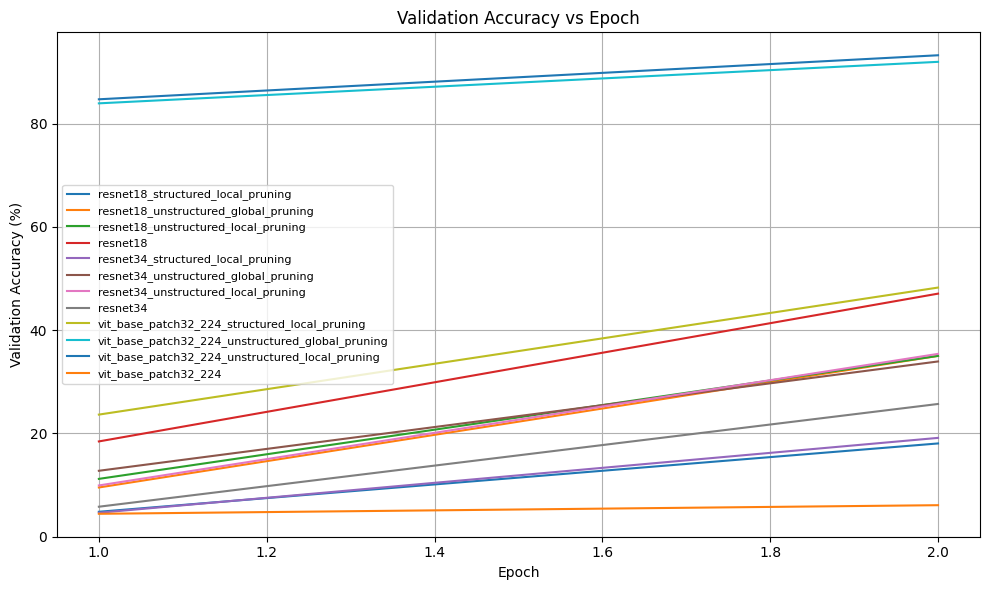

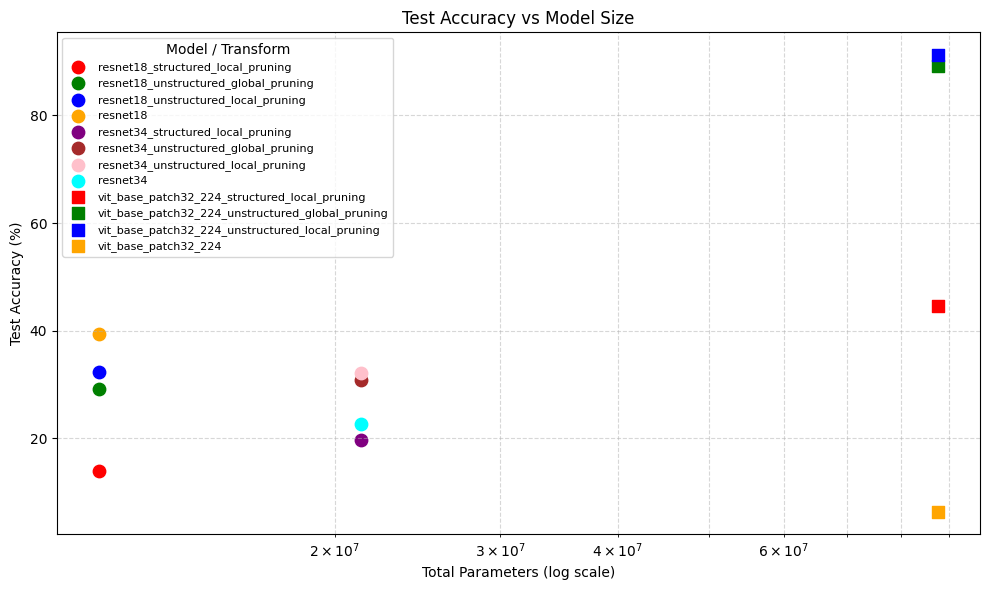

In [170]:
histories = get_or_compute_model_results(
	model_transforms=[structured_local_pruning, unstructured_global_pruning, unstructured_local_pruning]
)
plot_model_histories(histories)

# Deformable Convolutions

In [171]:
# nvm this is too slow im going with open source libraries, 15 minutes and only finish training 1 epoch 
class DeformableConv2d(nn.Module):
	def __init__(self, conv: nn.Conv2d, device=device):
		super().__init__()
		assert conv.kernel_size[0] == conv.kernel_size[1], "Only square kernels supported for simplicity"
		self.in_channels = conv.in_channels
		self.out_channels = conv.out_channels
		self.kernel_size = conv.kernel_size[0]
		self.stride = conv.stride
		self.padding = conv.padding
		self.dilation = conv.dilation
		self.groups = conv.groups
		self.bias = conv.bias is not None

		# Learnable offsets for each kernel position
		self.offset_conv = nn.Conv2d(
			self.in_channels,
			2 * self.kernel_size * self.kernel_size,
			kernel_size=self.kernel_size,
			padding=self.padding, # type: ignore
			bias=True
		)

		# Use the weights of the given conv
		self.weight = nn.Parameter(conv.weight.clone())
		if self.bias:
			assert conv.bias is not None, "conv.bias is None!"
			self.bias_param = nn.Parameter(conv.bias.clone())
		else:
			self.bias_param = None
		
		self.to(device)

	def forward(self, x):
		N, C, H, W = x.shape
		k = self.kernel_size
		offset = self.offset_conv(x)  # (N, 2*k*k, H, W)

		# build grid (H, W, 2)
		grid_y, grid_x = torch.meshgrid(
			torch.arange(H, device=x.device),
			torch.arange(W, device=x.device),
			indexing='ij',
		)
		base_grid = torch.stack((grid_x, grid_y), dim=-1).float().unsqueeze(0)  # (1, H, W, 2)
		norm = torch.tensor([W - 1, H - 1], device=x.device).reshape(1, 1, 1, 2)
		base_grid = (base_grid / norm * 2 - 1).expand(N, -1, -1, -1)  # (N, H, W, 2)

		# Reshape offsets
		offset = offset.view(N, k*k, 2, H, W).permute(0, 3, 4, 1, 2)  # (N, H, W, k*k, 2)
		outputs = []

		for i in range(k*k):
			off = offset[..., i, :]
			sample_grid = base_grid + off / norm * 2
			sampled = F.grid_sample(x, sample_grid, mode='bilinear', padding_mode='zeros', align_corners=True)
			# Use conv weights for this kernel element
			w = self.weight[:, :, i // k, i % k].unsqueeze(-1).unsqueeze(-1)
			b = self.bias_param if self.bias else None
			out = F.conv2d(sampled, w, bias=b, stride=self.stride, padding=0, dilation=self.dilation, groups=self.groups)
			outputs.append(out)

		return sum(outputs)

def deformable_convolutions_transform(
	model: nn.Module
) -> nn.Module:
	if isinstance(model, timm.models.vision_transformer.VisionTransformer):
		return model
	elif isinstance(model, timm.models.resnet.ResNet):
		for module_name, module in model.named_modules():
			if isinstance(module, nn.Conv2d):
				# find parent module
				parent = model
				*path, last = module_name.split('.')
				for p in path:
					parent = getattr(parent, p)
				# replace the conv
				setattr(parent, last, DeformableConv2d(module))
				module.requires_grad_(True)
	else:
		raise NotImplementedError(f"class {model.__class__} for object {model} has not been implemented")
	return model

In [ ]:
histories = get_or_compute_model_results(model_transforms=(deformable_convolutions_transform,))
plot_model_histories(histories)

Computing performance for 'resnet18_deformable_convolutions_transform'...
Ignored missing keys: ['fc.weight', 'fc.bias']
Ignored unexpected keys: []


Training Epochs (resnet18):   0%|          | 0/2 [00:00<?, ?epoch/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]